# THIS VERSION USES ALL DATA, NOT JUST PROTEIN CODING, AND MULTIREADS FROM ALIGNMENTS

In [1]:
import pandas as pd
import os 
import numpy as np
import scipy as sp
import scipy.stats as stats
import Bio
import rpy2
%load_ext rpy2.ipython

In [ ]:
####import reads files
reads_48 = pd.read_csv("reads_48.txt",sep='\t',index_col=0)
print(reads_48.shape)
reads_49 = pd.read_csv("reads_49.txt",sep='\t',index_col=0)
print(reads_49.shape)
reads_50 = pd.read_csv("reads_50.txt",sep='\t',index_col=0)
print(reads_50.shape)
# ####import ensembl protein coding file
# ens_pc = pd.read_csv("ensmbl_proteincoding.txt",sep='\t',index_col=0)
# ####filters by gene list from ensembl protein-coding
# reads_48 = reads_48.merge(ens_pc,how='inner',left_index=True,right_index=True)
# reads_48 = reads_48.drop("Gene name",axis=1)
# reads_49 = reads_49.merge(ens_pc,how='inner',left_index=True,right_index=True)
# reads_49 = reads_49.drop("Gene name",axis=1)
# reads_50 = reads_50.merge(ens_pc,how='inner',left_index=True,right_index=True)
# reads_50 = reads_50.drop("Gene name",axis=1)
###assign identity to each by extra level
reads_48.columns = pd.MultiIndex.from_product([reads_48.columns, ['ctrl']])
reads_48.columns.names = ['file','sample']
#
reads_49.columns = pd.MultiIndex.from_product([reads_49.columns, ['erl']])
reads_49.columns.names = ['file','sample']
#
reads_50.columns = pd.MultiIndex.from_product([reads_50.columns, ['roc']])
reads_50.columns.names = ['file','sample']
####merge files together
reads_all = reads_48.merge(reads_49,how='outer',left_index=True,right_index=True)
reads_all = reads_all.merge(reads_50,how='outer',left_index=True,right_index=True)
####save to file
reads_all.to_csv('reads_all.txt',sep='\t')
###then format by excel manually
print(reads_all.shape)

# Section 1, filtering using package 'scater'.

filter_by_total_counts
FALSE  TRUE 
    4    58 
filter_by_expr_features
FALSE  TRUE 
    2    60 
filter_genes
FALSE  TRUE 
10515 26713 


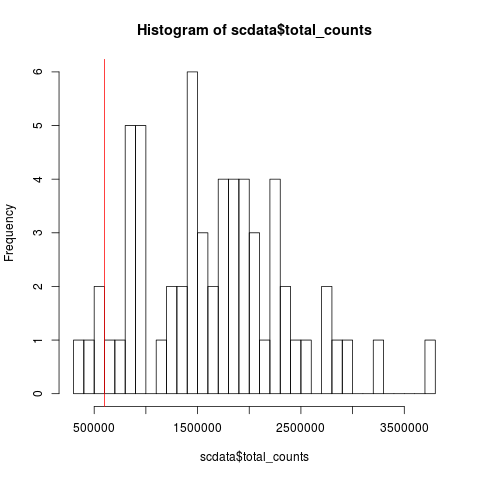

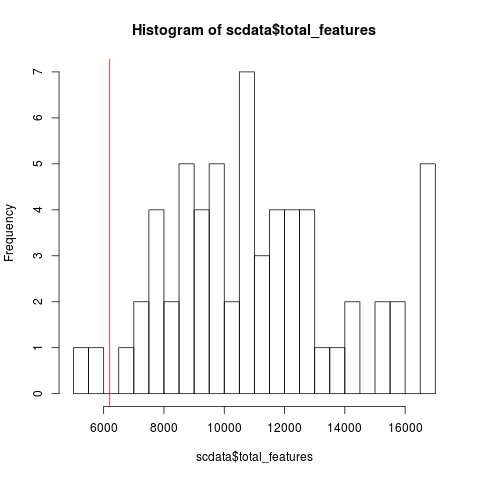

In [4]:
%%R

library(SingleCellExperiment)
library(scater)
library(scran)
options(stringsAsFactors = FALSE)

###import data and format
########
reads <- read.table("smart_counts.txt.csv",sep='\t',header=TRUE)
rownames(reads) <- reads$X
reads <- within(reads, rm("X"))
##to matrix
reads_m <- data.matrix(reads)
########
anno <- read.table("smart_anno.txt.csv",sep='\t',header=TRUE)
rownames(anno) <- anno$X
anno <- within(anno, rm("X"))
####### read into sce class
scdata <- SingleCellExperiment(assays = list(counts = reads_m), colData = anno)
###########################BEGIN CELL FILTERING###################
keep_feature <- rowSums(counts(scdata) > 0) > 0
scdata <- scdata[keep_feature, ]
####### do calculations
logcounts(scdata) <- log2(calculateCPM(scdata, use.size.factors = FALSE) + 1)
tpm(scdata) <- calculateTPM(scdata, effective_length = 5e4)
cpm(scdata) <- calculateCPM(scdata, use.size.factors = FALSE)
####metrics
scdata <- calculateQCMetrics(scdata)
##filter total counts
cutoff_reads = 0.6e6
##plot total counts
hist(
    scdata$total_counts,
    breaks = 25
)
abline(v = cutoff_reads, col = "red")
###cutoff by total counts
filter_by_total_counts <- (scdata$total_counts > cutoff_reads)
print(table(filter_by_total_counts))
##filter total features
cutoff_features = 6200
##plot total features (genes)
hist(
    scdata$total_features,
    breaks = 25
)
abline(v = cutoff_features, col = "red")
###cutoff by total features
filter_by_expr_features <- (scdata$total_features > cutoff_features)
print(table(filter_by_expr_features))
####filter by total counts, total features
# sufficient features (genes)
# sufficient molecules counted
scdata$use <- (filter_by_expr_features & filter_by_total_counts)
###########################END CELL FILTERING###################
###########################BEGIN CELL CYLCE FILTERING###################
hg.pairs <- readRDS(system.file("exdata", "human_cycle_markers.rds", package="scran"))
assigned <- cyclone(scdata, pairs=hg.pairs)
colData(scdata)$phase <- assigned$phases
###########################BEGIN GENE FILTERING###################
###filter number of cells each gene has to be at minimum present in
cutoff_numcells = 2
###plot
plotQC(scdata, type = "highest-expression")
###filter genes whose absolute counts are at least > 1 and present in at least (cutoff_numcell) # of cells
filter_genes <- apply(
    counts(scdata[ , colData(scdata)$use]), 
    1, 
    function(x) length(x[x > 1]) >= cutoff_numcells
)
rowData(scdata)$use <- filter_genes
print(table(filter_genes))
###save data
dim(scdata[rowData(scdata)$use, colData(scdata)$use])
saveRDS(scdata, file = "scater/filtered.rds")

# Section 2, basic visualization of technical bias and QC

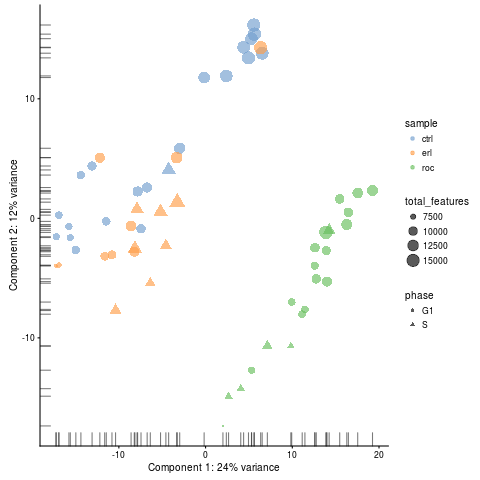

In [5]:
%%R

###plot PCA
library(SingleCellExperiment)
library(scater)
options(stringsAsFactors = FALSE)
###readin
scdata <- readRDS("scater/filtered.rds")
###subset by qc'd 
scdata.qc <- scdata[rowData(scdata)$use, colData(scdata)$use]
endog_genes <- !rowData(scdata.qc)$is_feature_control

plotPCA(
    scdata.qc,
    exprs_values = "logcounts",
    colour_by = "sample",
    size_by = "total_features",
    shape_by = "phase",
    draw_plot=TRUE,
    return_SCE=FALSE,
    ncomponents = 2
)



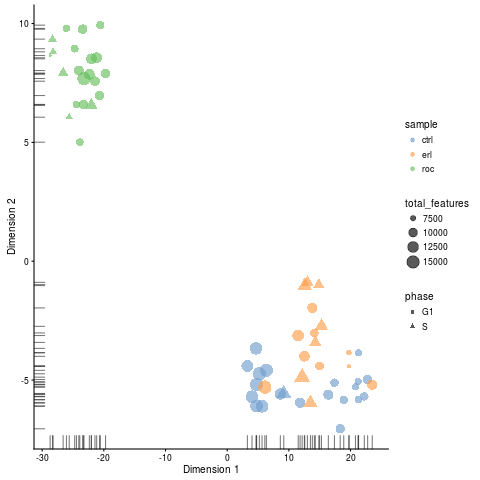

In [6]:
%%R

###plot TSNE
library(SingleCellExperiment)
library(scater)
options(stringsAsFactors = FALSE)
###readin
scdata <- readRDS("scater/filtered.rds")
###subset by qc'd 
scdata.qc <- scdata[rowData(scdata)$use, colData(scdata)$use]
endog_genes <- !rowData(scdata.qc)$is_feature_control

plotTSNE(
    scdata.qc,
    perplexity = 10,
    rand_seed = 123456,
    exprs_values = "logcounts",
    colour_by = "sample",
    size_by = "total_features",
    shape_by = "phase",
    draw_plot=TRUE,
    return_SCE=FALSE
)


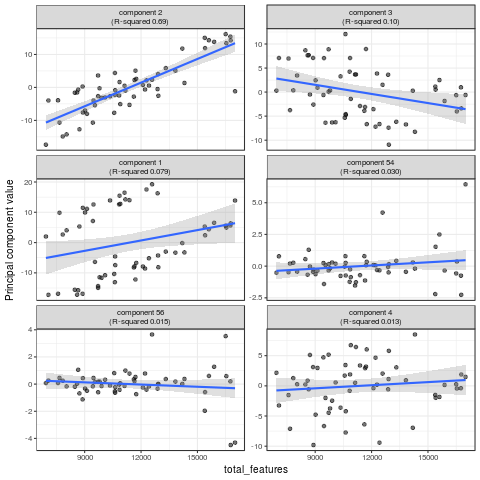

In [7]:
%%R

###find covariate correlation with PC using default method (logcounts(cpm))
library(SingleCellExperiment)
library(scater)
options(stringsAsFactors = FALSE)
###readin
scdata <- readRDS("scater/filtered.rds")
###subset by qc'd 
scdata.qc <- scdata[rowData(scdata)$use, colData(scdata)$use]
endog_genes <- !rowData(scdata.qc)$is_feature_control

plotQC(
    scdata.qc,
    type = "find-pcs",
    exprs_values = "logcounts",
    variable = "total_features"
)


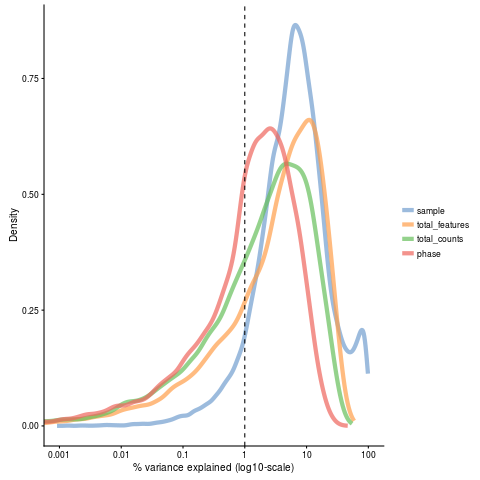

In [8]:
%%R

###find explanatory variables
library(SingleCellExperiment)
library(scater)
options(stringsAsFactors = FALSE)
###readin
scdata <- readRDS("scater/filtered.rds")
###subset by qc'd 
scdata.qc <- scdata[rowData(scdata)$use, colData(scdata)$use]
endog_genes <- !rowData(scdata.qc)$is_feature_control

plotQC(
    scdata.qc,
    type = "expl",
    exprs_values = "logcounts",
    variables = c(
        "total_features",
        "total_counts",
        "sample",
        "phase"
    )
)


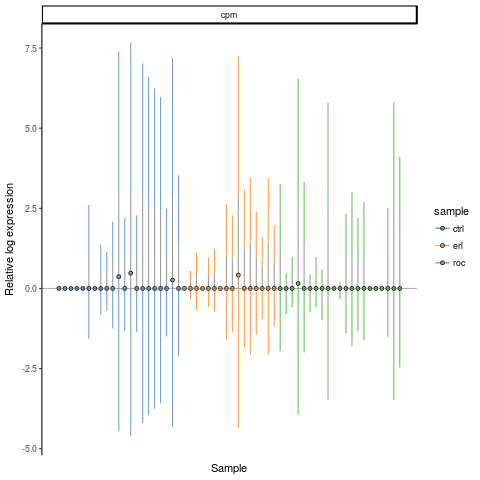

In [9]:
%%R

###find explanatory variables
library(SingleCellExperiment)
library(scater)
options(stringsAsFactors = FALSE)
###readin
scdata <- readRDS("scater/filtered.rds")
###subset by qc'd 
scdata.qc <- scdata[rowData(scdata)$use, colData(scdata)$use]
endog_genes <- !rowData(scdata.qc)$is_feature_control

plotRLE(
    scdata.qc[endog_genes, ], 
    exprs_mats = list(cpm = "logcounts"),
    exprs_logged = c(TRUE, TRUE),
    colour_by = "sample"
)

Very high correlation of total features with variance. Need to correct using method other than default method (logcounts(cpm)). Testing different correction methods.

correct using upper quartile method

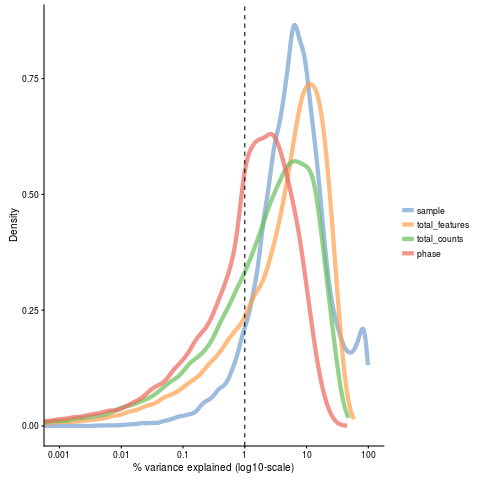

In [10]:
%%R

###bias correction with upperquartile method
library(SingleCellExperiment)
library(scater)
options(stringsAsFactors = FALSE)
###readin
scdata <- readRDS("scater/filtered.rds")
###subset by qc'd 
scdata.qc <- scdata[rowData(scdata)$use, colData(scdata)$use]
endog_genes <- !rowData(scdata.qc)$is_feature_control

scdata.qc <- normaliseExprs(
    scdata.qc,
    method = "upperquartile", 
    p = 0.99,
    return_log = TRUE,
    return_norm_as_exprs = FALSE
)

plotQC(
    scdata.qc,
    type = "expl",
    exprs_values = "norm_exprs",
    variables = c(
        "total_features",
        "total_counts",
        "sample",
        "phase"
    )
)


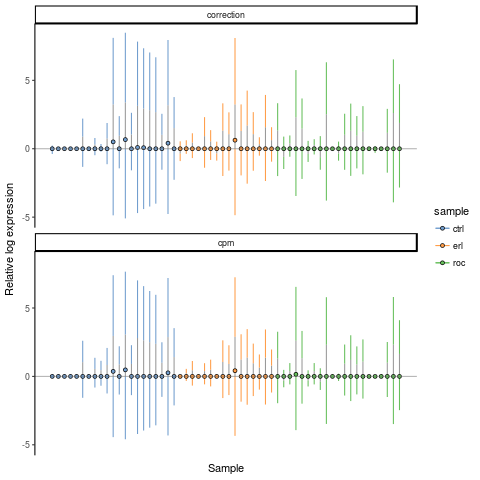

In [11]:
%%R

###bias correction with upperquartile method
library(SingleCellExperiment)
library(scater)
options(stringsAsFactors = FALSE)
###readin
scdata <- readRDS("scater/filtered.rds")
###subset by qc'd 
scdata.qc <- scdata[rowData(scdata)$use, colData(scdata)$use]
endog_genes <- !rowData(scdata.qc)$is_feature_control

scdata.qc <- normaliseExprs(
    scdata.qc,
    method = "upperquartile", 
    p = 0.99,
    return_log = TRUE,
    return_norm_as_exprs = FALSE
)

plotRLE(
    scdata.qc[endog_genes, ], 
    exprs_mats = list(cpm = "logcounts", correction = "norm_exprs"),
    exprs_logged = c(TRUE, TRUE),
    colour_by = "sample"
)

correct using RLE method

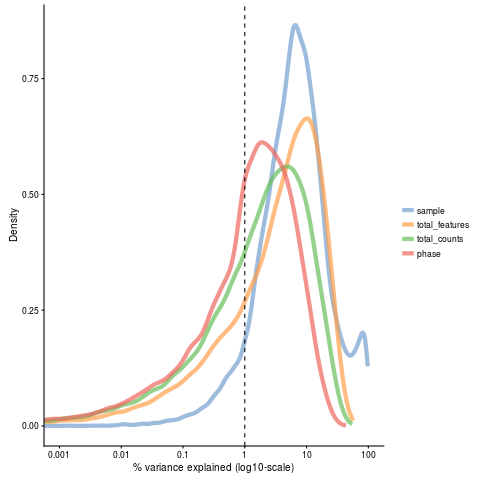

In [12]:
%%R

###bias correction with RLE method
library(SingleCellExperiment)
library(scater)
options(stringsAsFactors = FALSE)
###readin
scdata <- readRDS("scater/filtered.rds")
###subset by qc'd 
scdata.qc <- scdata[rowData(scdata)$use, colData(scdata)$use]
endog_genes <- !rowData(scdata.qc)$is_feature_control

scdata.qc <- normaliseExprs(
    scdata.qc,
    method = "RLE", 
    feature_set = endog_genes,
    return_log = TRUE,
    return_norm_as_exprs = FALSE
)

plotQC(
    scdata.qc,
    type = "expl",
    exprs_values = "norm_exprs",
    variables = c(
        "total_features",
        "total_counts",
        "sample",
        "phase"
    )
)


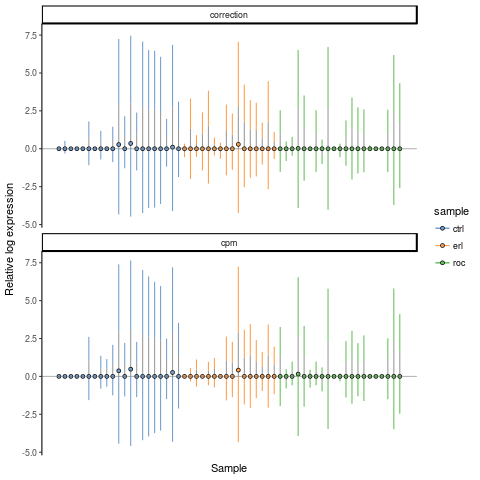

In [13]:
%%R

###bias correction with RLE method
library(SingleCellExperiment)
library(scater)
options(stringsAsFactors = FALSE)
###readin
scdata <- readRDS("scater/filtered.rds")
###subset by qc'd 
scdata.qc <- scdata[rowData(scdata)$use, colData(scdata)$use]
endog_genes <- !rowData(scdata.qc)$is_feature_control

scdata.qc <- normaliseExprs(
    scdata.qc,
    method = "RLE", 
    feature_set = endog_genes,
    return_log = TRUE,
    return_norm_as_exprs = FALSE
)

plotRLE(
    scdata.qc[endog_genes, ], 
    exprs_mats = list(cpm = "logcounts", correction = "norm_exprs"),
    exprs_logged = c(TRUE, TRUE),
    colour_by = "sample"
)


correct using TMM method

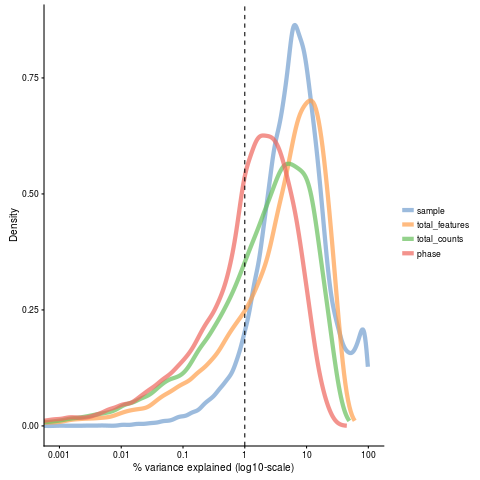

In [14]:
%%R

###bias correction using TMM
library(SingleCellExperiment)
library(scater)
options(stringsAsFactors = FALSE)
###readin
scdata <- readRDS("scater/filtered.rds")
###subset by qc'd 
scdata.qc <- scdata[rowData(scdata)$use, colData(scdata)$use]
endog_genes <- !rowData(scdata.qc)$is_feature_control

scdata.qc <- normaliseExprs(
    scdata.qc,
    method = "TMM",
    feature_set = endog_genes,
    return_log = TRUE,
    return_norm_as_exprs = FALSE
)

plotQC(
    scdata.qc,
    type = "expl",
    exprs_values = "norm_exprs",
    variables = c(
        "total_features",
        "total_counts",
        "sample",
        "phase"
    )
)


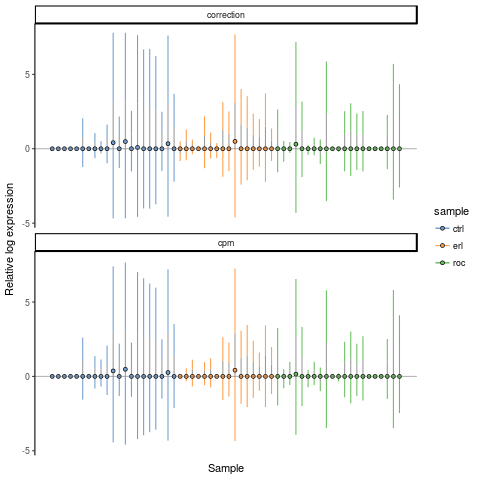

In [15]:
%%R

###bias correction using TMM
library(SingleCellExperiment)
library(scater)
options(stringsAsFactors = FALSE)
###readin
scdata <- readRDS("scater/filtered.rds")
###subset by qc'd 
scdata.qc <- scdata[rowData(scdata)$use, colData(scdata)$use]
endog_genes <- !rowData(scdata.qc)$is_feature_control

scdata.qc <- normaliseExprs(
    scdata.qc,
    method = "TMM",
    feature_set = endog_genes,
    return_log = TRUE,
    return_norm_as_exprs = FALSE
)

plotRLE(
    scdata.qc[endog_genes, ], 
    exprs_mats = list(cpm = "logcounts", correction = "norm_exprs"),
    exprs_logged = c(TRUE, TRUE),
    colour_by = "sample"
)


correct using scran

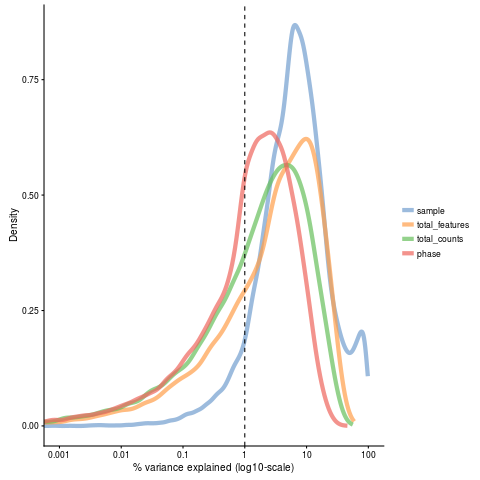

In [16]:
%%R

###bias correction using scran
library(SingleCellExperiment)
library(scater)
library(scran)
options(stringsAsFactors = FALSE)
###readin
scdata <- readRDS("scater/filtered.rds")
###subset by qc'd 
scdata.qc <- scdata[rowData(scdata)$use, colData(scdata)$use]
endog_genes <- !rowData(scdata.qc)$is_feature_control

scdata.qc <- computeSumFactors(scdata.qc)
scdata.qc <- normalize(scdata.qc)

scdata.qc

plotQC(
    scdata.qc,
    type = "expl",
    exprs_values = "logcounts",
    variables = c(
        "total_features",
        "total_counts",
        "sample",
        "phase"
    )
)


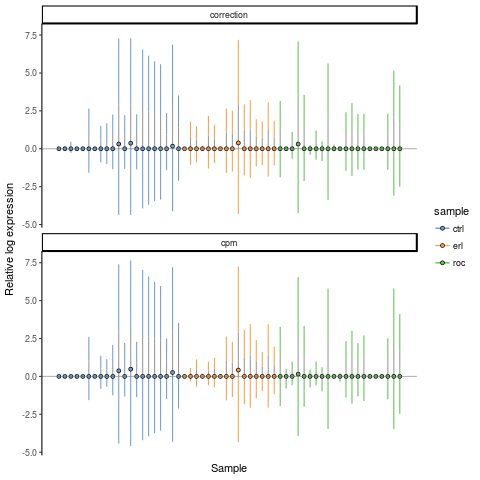

In [17]:
%%R

###bias correction using scran
library(SingleCellExperiment)
library(scater)
library(scran)
options(stringsAsFactors = FALSE)
###readin
scdata <- readRDS("scater/filtered.rds")
cpm(scdata) <- log2(calculateCPM(scdata, use.size.factors = FALSE) + 1)
###subset by qc'd 
scdata.qc <- scdata[rowData(scdata)$use, colData(scdata)$use]
endog_genes <- !rowData(scdata.qc)$is_feature_control



scdata.qc <- computeSumFactors(scdata.qc)
scdata.qc <- normalize(scdata.qc)

plotRLE(
    scdata.qc[endog_genes, ], 
    exprs_mats = list(cpm = "cpm", correction = "logcounts"),
    exprs_logged = c(TRUE, TRUE),
    colour_by = "sample"
)

scran looks like best correction method for library size, use for full dataset.

In [18]:
%%R

###bias correction using scran
library(SingleCellExperiment)
library(scater)
library(scran)
options(stringsAsFactors = FALSE)
###readin
scdata <- readRDS("scater/filtered.rds")
cpm(scdata) <- log2(calculateCPM(scdata, use.size.factors = FALSE) + 1)
###subset by qc'd 
scdata.qc <- scdata[rowData(scdata)$use, colData(scdata)$use]
endog_genes <- !rowData(scdata.qc)$is_feature_control

scdata.qc <- computeSumFactors(scdata.qc)
scdata.qc <- normalize(scdata.qc)

###save file
saveRDS(scdata.qc, file = "scater/filtered_1_scran.rds")

Check gene variance 

                     mean    total      bio     tech      p.value          FDR
ENSG00000281181  9.508230 53.53818 48.47834 5.059840 3.164126e-92 2.935658e-88
ENSG00000280614  9.508153 53.53723 48.47730 5.059936 3.196048e-92 2.935658e-88
ENSG00000280800  9.507916 53.53429 48.47406 5.060231 3.296887e-92 2.935658e-88
ENSG00000281383 10.861190 29.54678 25.98653 3.560247 7.167296e-67 4.786499e-63
ENSG00000233476  7.173431 20.06332 11.88494 8.178378 6.513831e-09 1.933377e-05
ENSG00000196205  7.497328 18.26889 10.51056 7.758335 3.584792e-08 5.632973e-05


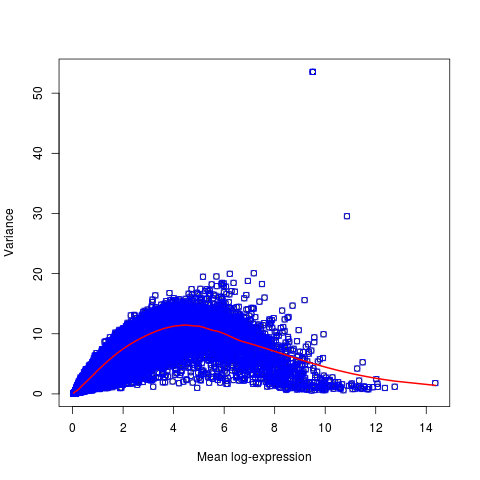

In [19]:
%%R

###check gene variance
library(SingleCellExperiment)
library(scater)
library(scran)
options(stringsAsFactors = FALSE)
###readin
scdata <- readRDS("scater/filtered_1_scran.rds")
###subset by qc'd 
scdata.qc <- scdata[rowData(scdata)$use, colData(scdata)$use]
endog_genes <- !rowData(scdata.qc)$is_feature_control

fit <- trendVar(logcounts(scdata.qc))
decomp <- decomposeVar(logcounts(scdata.qc), fit)
top.hvgs <- order(decomp$bio, decreasing=TRUE)
print(head(decomp[top.hvgs,]))


plot(decomp$mean, decomp$total, xlab="Mean log-expression", ylab="Variance")
o <- order(decomp$mean)
points(fit$mean, fit$var, col="blue", pch=0.5)
lines(decomp$mean[o], decomp$tech[o], col="red", lwd=2)

correct batch effects

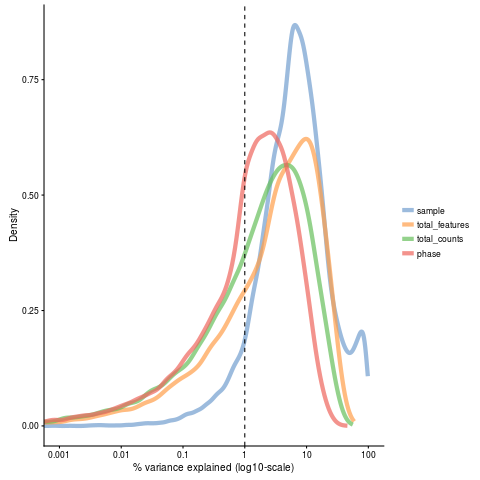

In [20]:
%%R

###baseline 
library(SingleCellExperiment)
library(scater)
library(scran)
options(stringsAsFactors = FALSE)
###readin
scdata <- readRDS("scater/filtered_1_scran.rds")
###subset by qc'd 
scdata.qc <- scdata[rowData(scdata)$use, colData(scdata)$use]
endog_genes <- !rowData(scdata.qc)$is_feature_control

scdata.qc <- computeSumFactors(scdata.qc)
scdata.qc <- normalize(scdata.qc)

scdata.qc

plotQC(
    scdata.qc,
    type = "expl",
    exprs_values = "logcounts",
    variables = c(
        "total_features",
        "total_counts",
        "sample",
        "phase"
    )
)


/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: mgcv

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: nlme

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 
Attaching package: ‘nlme’


  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: The following object is masked from ‘package:IRanges’:

    collapse


  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: This is mgcv 1.8-22. For overview type 'help("mgcv-package")'.

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRu

Standardizing Data across genes


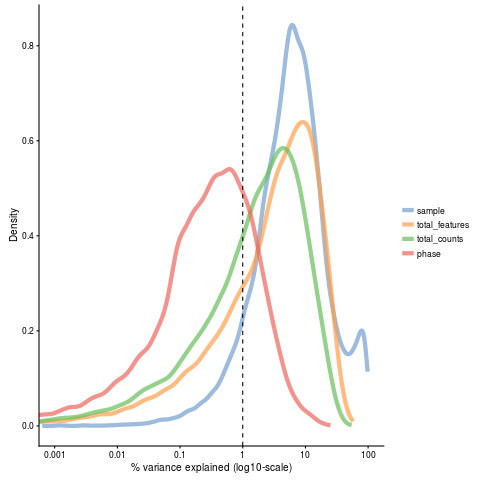

In [21]:
%%R

###bias correction using combat
library(SingleCellExperiment)
library(scater)
library(scran)
library(sva)
options(stringsAsFactors = FALSE)
###readin
scdata <- readRDS("scater/filtered_1_scran.rds")
cpm(scdata) <- log2(calculateCPM(scdata, use.size.factors = FALSE) + 1)
###subset by qc'd 
scdata.qc <- scdata[rowData(scdata)$use, colData(scdata)$use]
endog_genes <- !rowData(scdata.qc)$is_feature_control

combat_data <- logcounts(scdata.qc)

mod_data <- as.data.frame(t(combat_data))

mod0 = model.matrix(~ 1, data = mod_data) 

mod1 = model.matrix(~ scdata.qc$sample, data = mod_data) 

mod2 = model.matrix(~ scdata.qc$total_features, data = mod_data)

assay(scdata.qc, "combat") <- ComBat(
    dat = t(mod_data), 
    batch = factor(scdata.qc$phase), 
    mod = mod0,
    par.prior = TRUE,
    prior.plots = FALSE
)

plotQC(
    scdata.qc,
    type = "expl",
    exprs_values = "combat",
    variables = c(
        "total_features",
        "total_counts",
        "sample",
        "phase"
    )
)

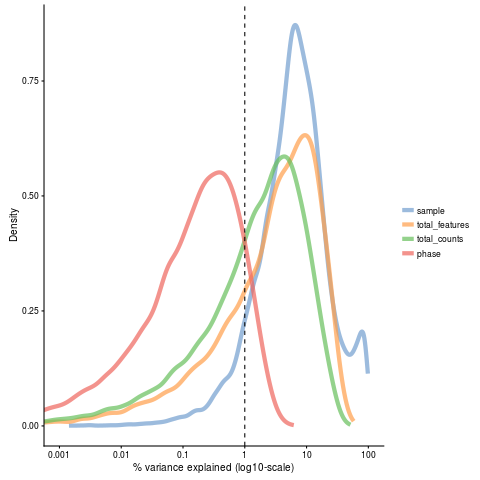

In [22]:
%%R

###bias correction using generalized linear model
library(SingleCellExperiment)
library(scater)
library(scran)
library(sva)
options(stringsAsFactors = FALSE)
###readin
scdata <- readRDS("scater/filtered_1_scran.rds")
cpm(scdata) <- log2(calculateCPM(scdata, use.size.factors = FALSE) + 1)
###subset by qc'd 
scdata.qc <- scdata[rowData(scdata)$use, colData(scdata)$use]
endog_genes <- !rowData(scdata.qc)$is_feature_control

glm_fun <- function(g, batch, indi) {
  model <- glm(g ~ batch + indi)
  model$coef[1] <- 0 # replace intercept with 0 to preserve reference batch.
  return(model$coef)
}
effects <- apply(
    logcounts(scdata.qc), 
    1, 
    glm_fun, 
    batch = scdata.qc$phase, 
    indi = scdata.qc$sample
)
corrected <- logcounts(scdata.qc) - t(effects[as.numeric(factor(scdata.qc$phase)), ])
assay(scdata.qc, "glm") <- corrected

plotQC(
    scdata.qc,
    type = "expl",
    exprs_values = "glm",
    variables = c(
        "total_features",
        "total_counts",
        "sample",
        "phase"
    )
)

GLM seems best, correct using that model.

In [23]:
%%R

###bias correction using generalized linear model, save to "exprs" slot
library(SingleCellExperiment)
library(scater)
library(scran)
library(sva)
options(stringsAsFactors = FALSE)
###readin
scdata <- readRDS("scater/filtered_1_scran.rds")
cpm(scdata) <- log2(calculateCPM(scdata, use.size.factors = FALSE) + 1)
###subset by qc'd 
scdata.qc <- scdata[rowData(scdata)$use, colData(scdata)$use]
endog_genes <- !rowData(scdata.qc)$is_feature_control

glm_fun <- function(g, batch, indi) {
  model <- glm(g ~ batch + indi)
  model$coef[1] <- 0 # replace intercept with 0 to preserve reference batch.
  return(model$coef)
}
effects <- apply(
    logcounts(scdata.qc), 
    1, 
    glm_fun, 
    batch = scdata.qc$phase, 
    indi = scdata.qc$sample
)
corrected <- logcounts(scdata.qc) - t(effects[as.numeric(factor(scdata.qc$phase)), ])
assay(scdata.qc, "exprs") <- corrected

###save file
saveRDS(scdata.qc, file = "scater/filtered_2_glm.rds")

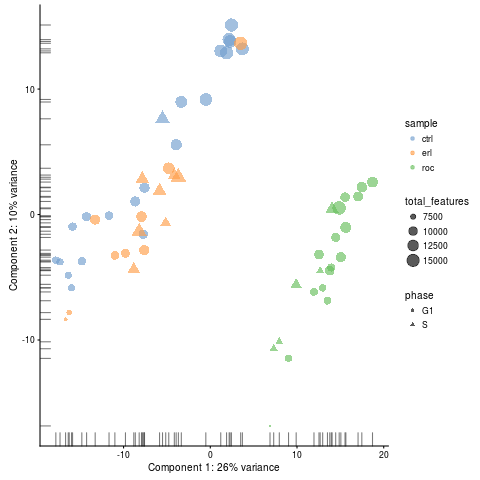

In [24]:
%%R

###plot PCA
library(SingleCellExperiment)
library(scater)
options(stringsAsFactors = FALSE)
###readin
scdata <- readRDS("scater/filtered_2_glm.rds")
###subset by qc'd 
scdata.qc <- scdata[rowData(scdata)$use, colData(scdata)$use]
endog_genes <- !rowData(scdata.qc)$is_feature_control

plotPCA(
    scdata.qc,
    exprs_values = "exprs",
    colour_by = "sample",
    size_by = "total_features",
    shape_by = "phase",
    draw_plot=TRUE,
    return_SCE=FALSE,
    ncomponents = 2
)



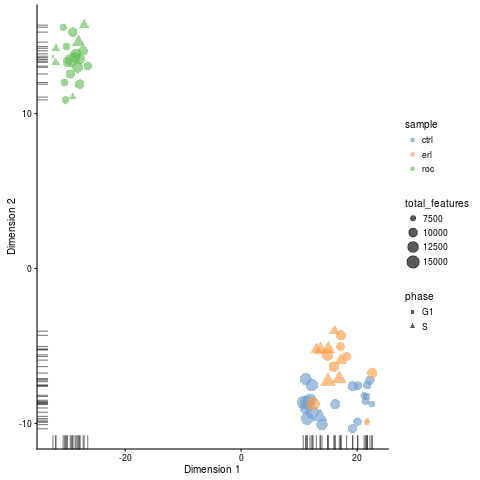

In [25]:
%%R

###plot TSNE
library(SingleCellExperiment)
library(scater)
options(stringsAsFactors = FALSE)
###readin
scdata <- readRDS("scater/filtered_2_glm.rds")
###subset by qc'd 
scdata.qc <- scdata[rowData(scdata)$use, colData(scdata)$use]
endog_genes <- !rowData(scdata.qc)$is_feature_control

plotTSNE(
    scdata.qc,
    perplexity = 10,
    rand_seed = 123456,
    exprs_values = "exprs",
    colour_by = "sample",
    size_by = "total_features",
    shape_by = "phase",
    draw_plot=TRUE,
    return_SCE=FALSE
)

# Section 3, biological analysis

cluster with SC3

In [56]:
%%R

###
library(SingleCellExperiment)
library(scater)
library(SC3)
options(stringsAsFactors = FALSE)
###readin
scdata <- readRDS("scater/filtered_2_glm.rds")

scdata <- sc3_estimate_k(scdata)

print(metadata(scdata)$sc3$k_estimation)

scdata <- sc3(scdata, ks = 2:10, biology = TRUE)

###save file
saveRDS(scdata, file = "scater/filtered_3_sc3.rds")

[1] 4



plot correlation heatmaps for different cluster sizes

[1] "k = 2-10"


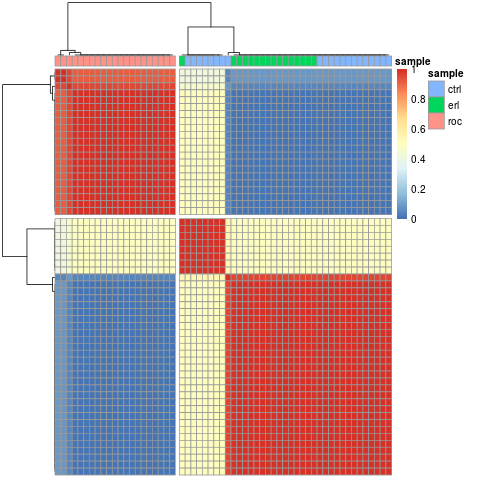

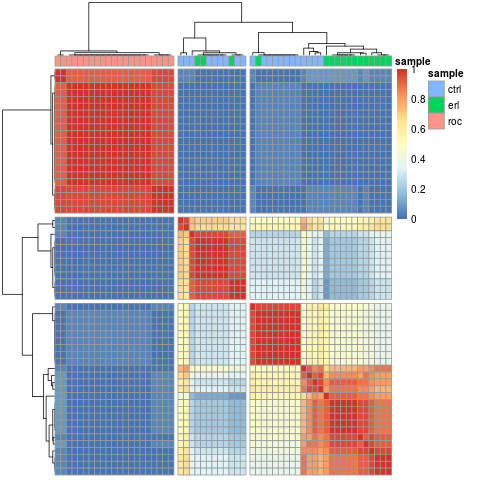

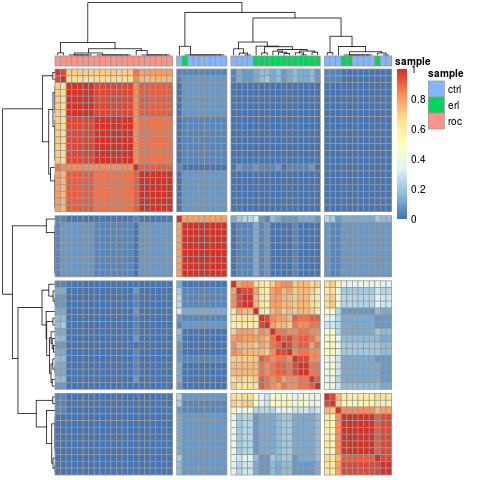

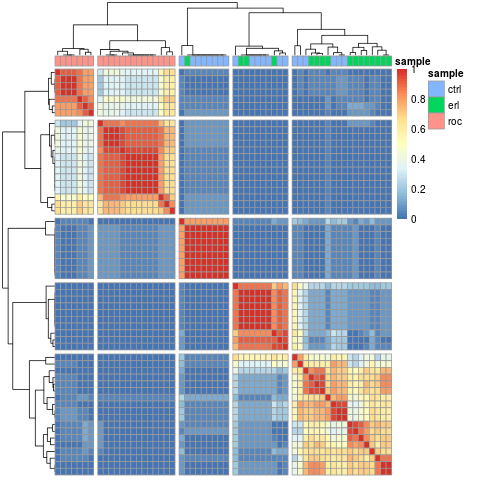

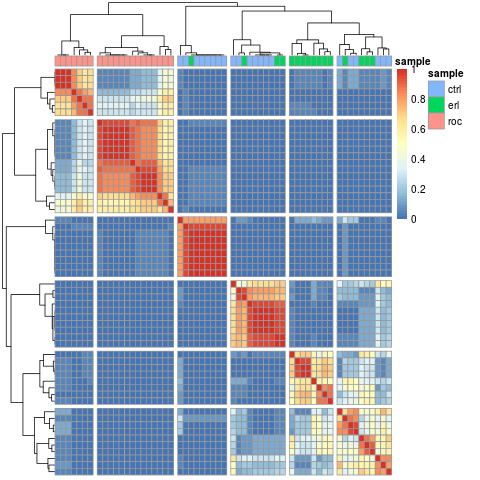

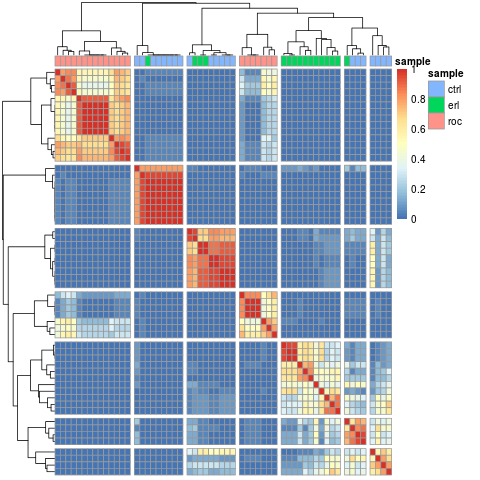

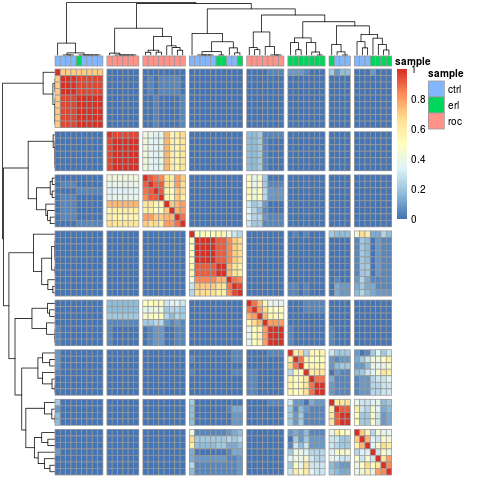

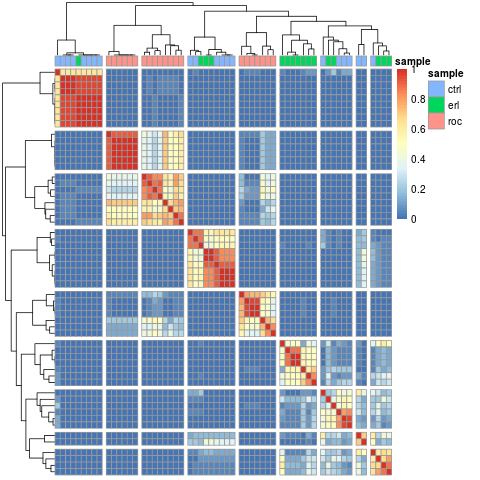

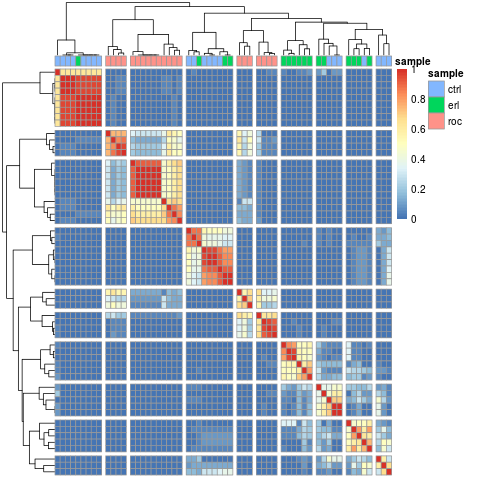

In [34]:
%%R

print("k = 2-10")
sc3_plot_consensus(scdata, k = 2, show_pdata = "sample")
sc3_plot_consensus(scdata, k = 3, show_pdata = "sample")
sc3_plot_consensus(scdata, k = 4, show_pdata = "sample")
sc3_plot_consensus(scdata, k = 5, show_pdata = "sample")
sc3_plot_consensus(scdata, k = 6, show_pdata = "sample")
sc3_plot_consensus(scdata, k = 7, show_pdata = "sample")
sc3_plot_consensus(scdata, k = 8, show_pdata = "sample")
sc3_plot_consensus(scdata, k = 9, show_pdata = "sample")
sc3_plot_consensus(scdata, k = 10, show_pdata = "sample")

plot silhouttes for different cluster sizes

[1] "k = 2-10"


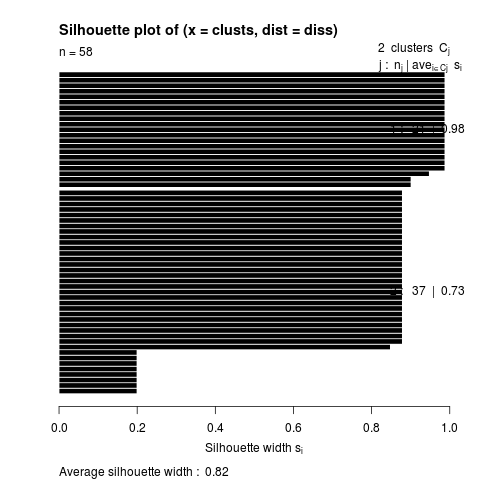

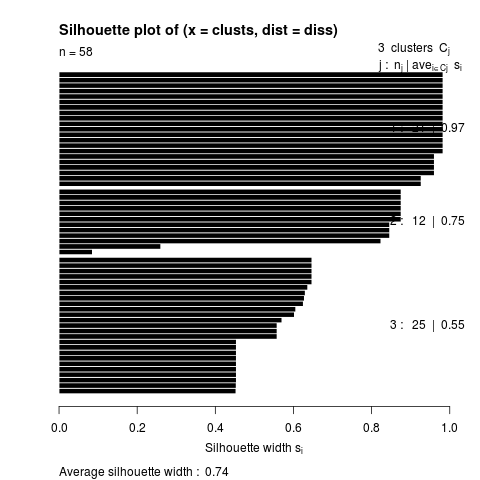

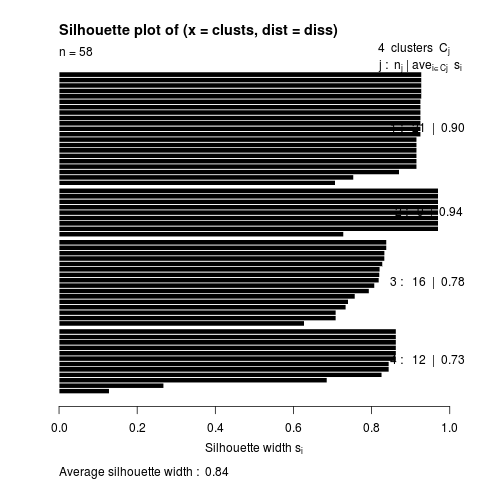

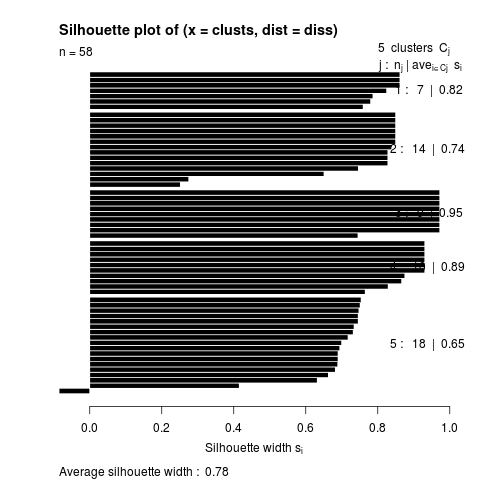

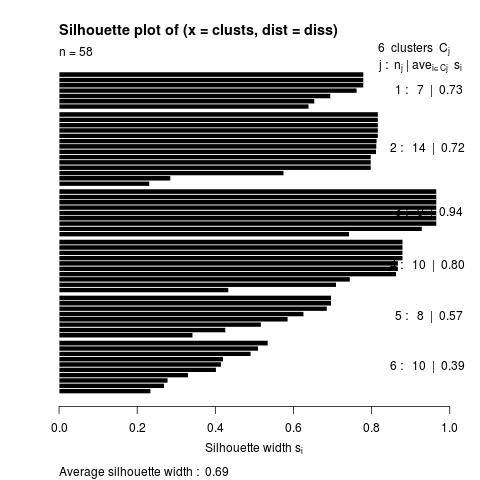

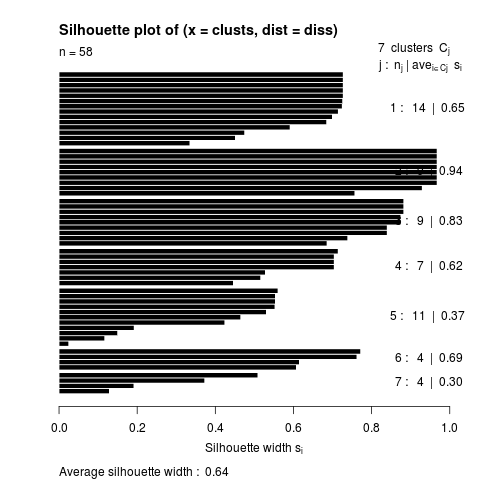

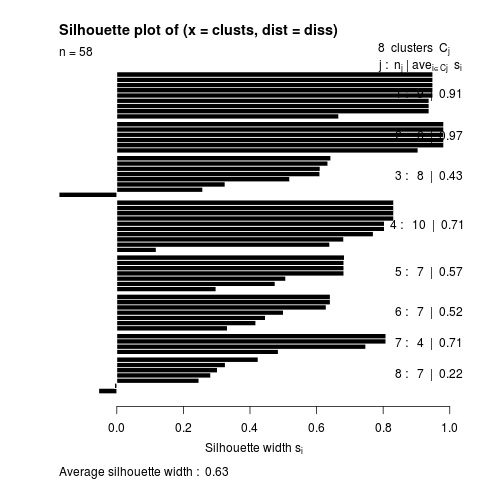

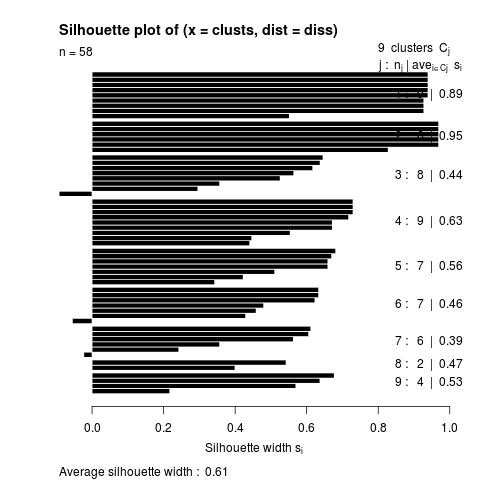

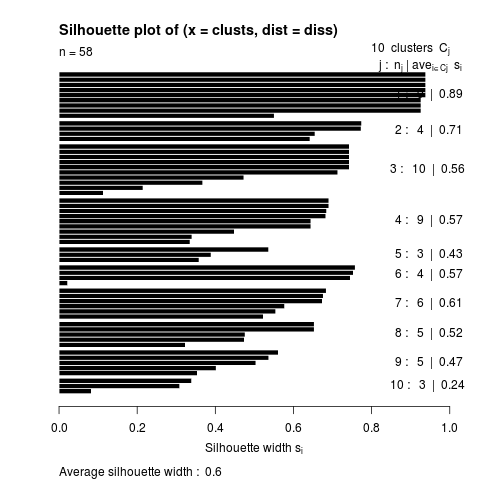

In [29]:
%%R

print("k = 2-10")
sc3_plot_silhouette(scdata, k = 2)
sc3_plot_silhouette(scdata, k = 3)
sc3_plot_silhouette(scdata, k = 4)
sc3_plot_silhouette(scdata, k = 5)
sc3_plot_silhouette(scdata, k = 6)
sc3_plot_silhouette(scdata, k = 7)
sc3_plot_silhouette(scdata, k = 8)
sc3_plot_silhouette(scdata, k = 9)
sc3_plot_silhouette(scdata, k = 10)

plot expression heatmap for different cluster sizes

[1] "k = 2-10"


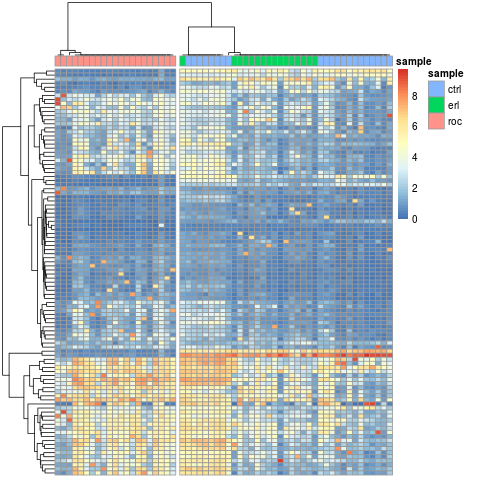

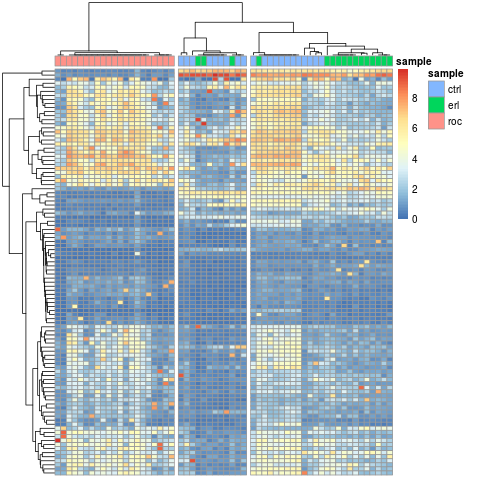

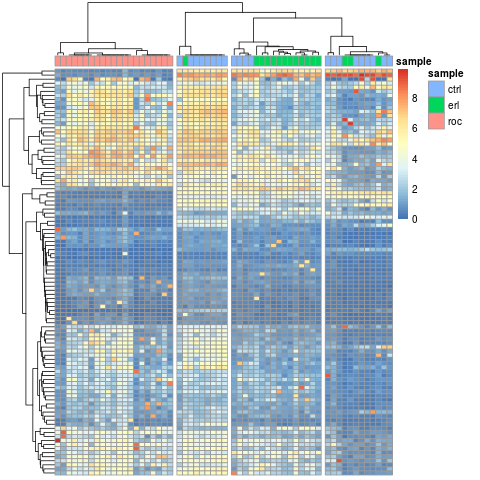

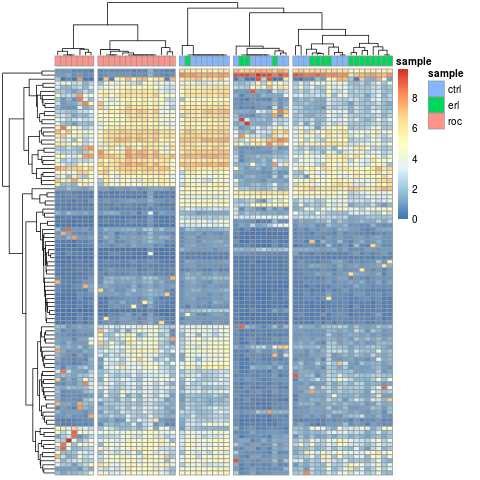

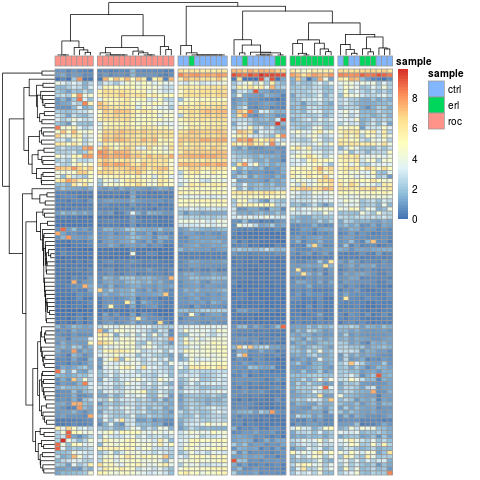

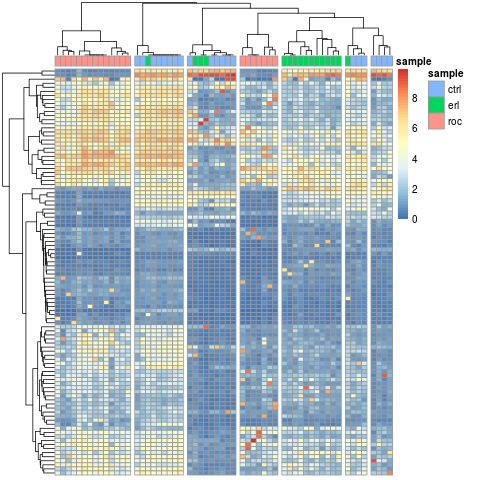

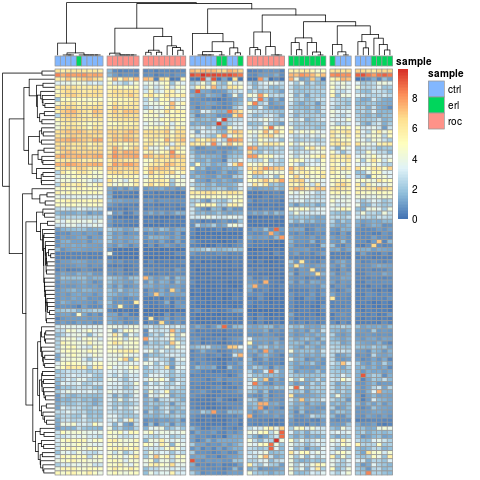

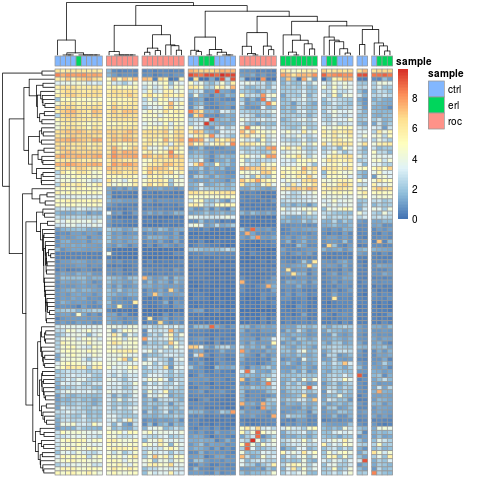

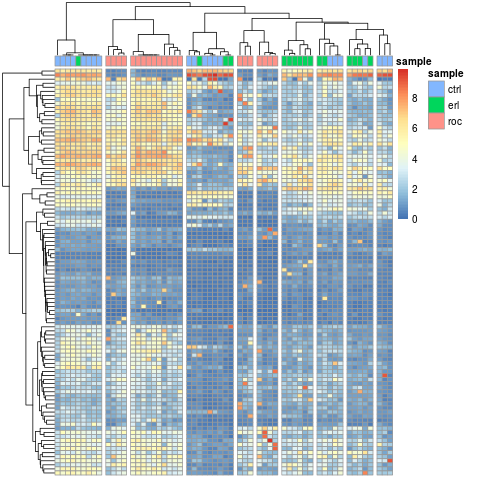

In [30]:
%%R

print("k = 2-10")
sc3_plot_expression(scdata, k = 2, show_pdata = "sample")
sc3_plot_expression(scdata, k = 3, show_pdata = "sample")
sc3_plot_expression(scdata, k = 4, show_pdata = "sample")
sc3_plot_expression(scdata, k = 5, show_pdata = "sample")
sc3_plot_expression(scdata, k = 6, show_pdata = "sample")
sc3_plot_expression(scdata, k = 7, show_pdata = "sample")
sc3_plot_expression(scdata, k = 8, show_pdata = "sample")
sc3_plot_expression(scdata, k = 9, show_pdata = "sample")
sc3_plot_expression(scdata, k = 10, show_pdata = "sample")

Silhoutte analysis showed 3,6,10 clusters seemed best for the data. Saving figures for these clusters.

In [31]:
%%R

#####saving plots for 3 clusters
sc3_3 <- plotPCA(scdata, colour_by = "sc3_3_clusters")

###save picture
pdf("sc3_3_clusters_pca_1.pdf")
plot(sc3_3)
dev.off()

sc3_3 <- plotPCA(scdata, colour_by = "sc3_3_clusters", shape_by = "sample")

###save picture
pdf("sc3_3_clusters_pca_2.pdf")
plot(sc3_3)
dev.off()

sc3_3 <- plotTSNE(
    scdata, 
    perplexity = 5, 
    rand_seed = 123456, 
    return_SCE=FALSE, 
    colour_by = "sc3_3_clusters"
)

###save picture
pdf("sc3_3_clusters_tsne_1.pdf")
plot(sc3_3)
dev.off()

sc3_3 <- plotTSNE(
    scdata, 
    perplexity = 5, 
    rand_seed = 123456, 
    return_SCE=FALSE, 
    colour_by = "sc3_3_clusters", 
    shape_by = "sample"
)

###save picture
pdf("sc3_3_clusters_tsne_2.pdf")
plot(sc3_3)
dev.off()

png 
  2 


In [32]:
%%R

#####saving plots for 6 clusters
sc3_6 <- plotPCA(scdata, colour_by = "sc3_6_clusters")

###save picture
pdf("sc3_6_clusters_pca_1.pdf")
plot(sc3_6)
dev.off()

sc3_6 <- plotPCA(scdata, colour_by = "sc3_6_clusters", shape_by = "sample")

###save picture
pdf("sc3_6_clusters_pca_2.pdf")
plot(sc3_6)
dev.off()

sc3_6 <- plotTSNE(
    scdata, 
    perplexity = 5, 
    rand_seed = 123456, 
    return_SCE=FALSE, 
    colour_by = "sc3_6_clusters"
)

###save picture
pdf("sc3_6_clusters_tsne_1.pdf")
plot(sc3_6)
dev.off()

sc3_6 <- plotTSNE(
    scdata, 
    perplexity = 5, 
    rand_seed = 123456, 
    return_SCE=FALSE, 
    colour_by = "sc3_6_clusters", 
    shape_by = "sample"
)

###save picture
pdf("sc3_6_clusters_tsne_2.pdf")
plot(sc3_6)
dev.off()

png 
  2 


In [33]:
%%R

#####saving plots for 10 clusters
sc3_10 <- plotPCA(scdata, colour_by = "sc3_10_clusters")

###save picture
pdf("sc3_10_clusters_pca_1.pdf")
plot(sc3_10)
dev.off()

sc3_10 <- plotPCA(scdata, colour_by = "sc3_10_clusters", shape_by = "sample")

###save picture
pdf("sc3_10_clusters_pca_2.pdf")
plot(sc3_10)
dev.off()

sc3_10 <- plotTSNE(
    scdata, 
    perplexity = 5, 
    rand_seed = 123456, 
    return_SCE=FALSE, 
    colour_by = "sc3_10_clusters"
)

###save picture
pdf("sc3_10_clusters_tsne_1.pdf")
plot(sc3_10)
dev.off()

sc3_10 <- plotTSNE(
    scdata, 
    perplexity = 5, 
    rand_seed = 123456, 
    return_SCE=FALSE, 
    colour_by = "sc3_10_clusters", 
    shape_by = "sample"
)

###save picture
pdf("sc3_10_clusters_tsne_2.pdf")
plot(sc3_10)
dev.off()

png 
  2 


In [35]:
%%R

#####saving plots for 4 clusters
sc3_4 <- plotPCA(scdata, colour_by = "sc3_4_clusters")

###save picture
pdf("sc3_4_clusters_pca_1.pdf")
plot(sc3_4)
dev.off()

sc3_4 <- plotPCA(scdata, colour_by = "sc3_4_clusters", shape_by = "sample")

###save picture
pdf("sc3_4_clusters_pca_2.pdf")
plot(sc3_4)
dev.off()

sc3_4 <- plotTSNE(
    scdata, 
    perplexity = 5, 
    rand_seed = 123456, 
    return_SCE=FALSE, 
    colour_by = "sc3_4_clusters"
)

###save picture
pdf("sc3_4_clusters_tsne_1.pdf")
plot(sc3_4)
dev.off()

sc3_4 <- plotTSNE(
    scdata, 
    perplexity = 5, 
    rand_seed = 123456, 
    return_SCE=FALSE, 
    colour_by = "sc3_4_clusters", 
    shape_by = "sample"
)

###save picture
pdf("sc3_4_clusters_tsne_2.pdf")
plot(sc3_4)
dev.off()

png 
  2 


# Feature Selection

/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: numDeriv

  warnings.warn(x, RRuntimeWarning)


[1] 26713    58
[1] 24815    58


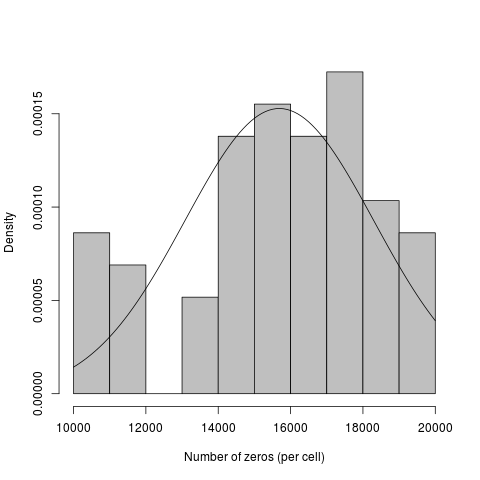

In [36]:
%%R

####clean data for M3Drop
library(scRNA.seq.funcs)
library(matrixStats)
library(M3Drop)
library(RColorBrewer)
set.seed(1)


scdata <- readRDS("scater/filtered_3_sc3.rds")
cellLabels <- colData(scdata)$sample

scdata_list <- M3DropCleanData(
    counts(scdata),
    labels = cellLabels,
    is.counts = TRUE
)

####data formatting
expr_matrix <- scdata_list$data # Normalized & filtered expression matrix
celltype_labs <- factor(scdata_list$labels) # filtered cell-type labels
cell_colors <- brewer.pal(max(3,length(unique(celltype_labs))), "Set3")

print(dim(counts(scdata)))
print(dim(expr_matrix))

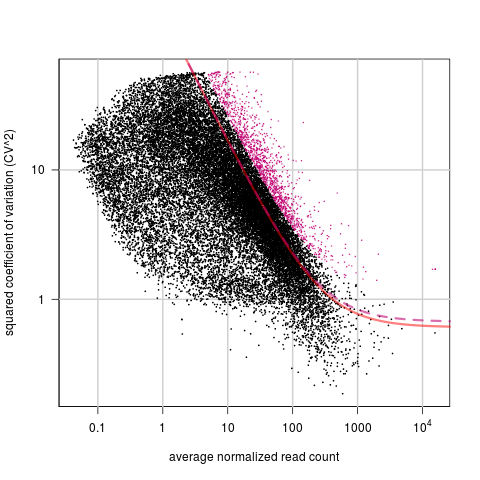

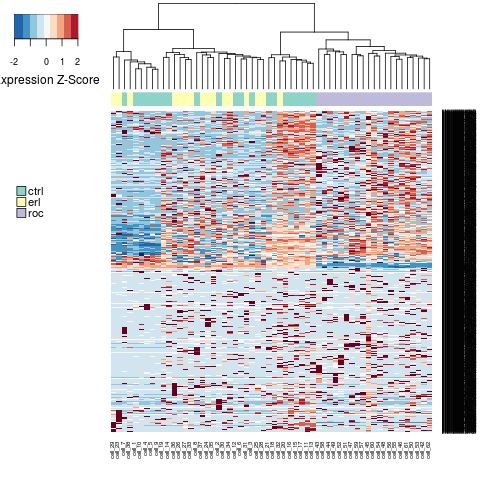

In [37]:
%%R

####find DE features using highly variable gene model (Brennecke)
Brennecke_HVG <- BrenneckeGetVariableGenes(
    expr_matrix,
    fdr = 0.02,
    minBiolDisp = 0.25
)

####plot HVG results
M3DropExpressionHeatmap(
    Brennecke_HVG,
    expr_matrix,
    cell_labels = celltype_labs
)


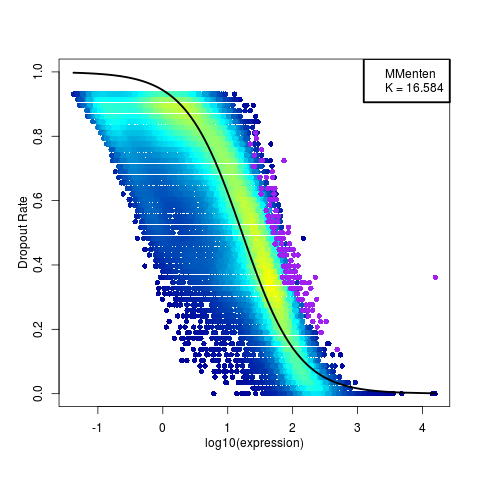

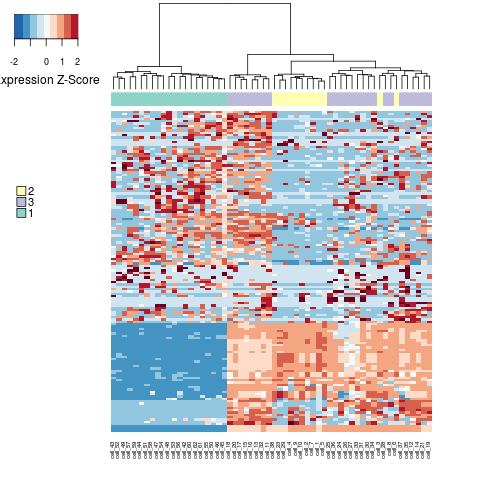

In [40]:
%%R
####fitted to MM plot, different method
M3Drop_genes <- M3DropDifferentialExpression(
    expr_matrix,
    mt_method = "fdr",
    mt_threshold = 0.1
)

####plot HVG results
M3DropExpressionHeatmap(
    M3Drop_genes,
    expr_matrix,
    cell_labels = celltype_labs
)



[1] 26713    58
[1] 24815    58


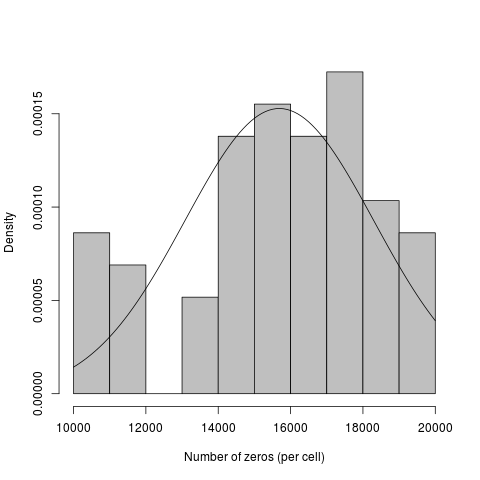

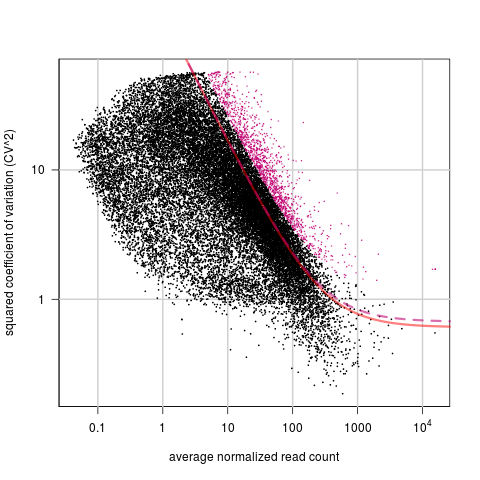

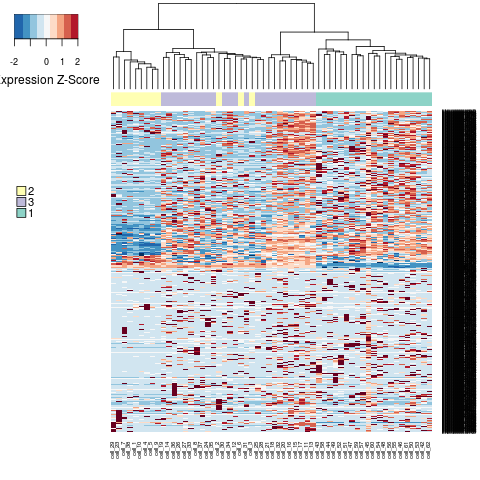

In [39]:
%%R

##########################overlay with SC3 clusters

####clean data for M3Drop
library(scRNA.seq.funcs)
library(matrixStats)
library(M3Drop)
library(RColorBrewer)
set.seed(1)


scdata <- readRDS("scater/filtered_3_sc3.rds")
cellLabels <- colData(scdata)$sc3_3_clusters

scdata_list <- M3DropCleanData(
    counts(scdata),
    labels = cellLabels,
    is.counts = TRUE
)

####data formatting
expr_matrix <- scdata_list$data # Normalized & filtered expression matrix
celltype_labs <- factor(scdata_list$labels) # filtered cell-type labels
cell_colors <- brewer.pal(max(3,length(unique(celltype_labs))), "Set3")

print(dim(counts(scdata)))
print(dim(expr_matrix))

####find DE features using highly variable gene model (Brennecke)
Brennecke_HVG <- BrenneckeGetVariableGenes(
    expr_matrix,
    fdr = 0.02,
    minBiolDisp = 0.25
)

####plot HVG results
M3DropExpressionHeatmap(
    Brennecke_HVG,
    expr_matrix,
    cell_labels = celltype_labs
)


In [47]:
%%R

print(length(Brennecke_HVG))
print(dim(M3Drop_genes))

[1] 1073
[1] 138   3


# Process in python

In [54]:
%%R
mydata = Brennecke_HVG
write.table(mydata, "scater/filtered_HVG.txt", sep="\t") 
mydata = M3Drop_genes
write.table(mydata, "scater/filtered_M3Drop_genes.txt", sep="\t") 
write.table(exprs(scdata), "scater/filtered_exprs.txt", sep="\t")
write.table(counts(scdata), "scater/filtered_counts.txt", sep="\t")

write.table(scdata$sc3_4_clusters, "scater/filtered_4_sc3.txt", sep="\t")
write.table(scdata$file, "scater/filtered_file.txt", sep="\t")

In [50]:
def print_cluster4_genevals(gene,cluster4_index):
####
    cluster4 = []
    for num in cluster4_index:
        name = 'cell_'+num
        cluster4.append(expr[name].loc[gene])
    ####
    print('cluster4',np.average(cluster4))
    print(len(cluster4))
    ####
    cluster_total = list(expr.columns)
    cluster_not = list(cluster_total)
    # print(cluster_total)
    for cell in cluster_total:
    #     print("dddddd",cell)
        for num in cluster4_index:
            name = 'cell_'+num
    #         print(name)
            if cell == name:
                cluster_not.remove(cell)
    #             print('removed',cell)
    # print(cluster_not)
    ####
    cluster4_not = []
    for cell in cluster_not:
        cluster4_not.append(expr[cell].loc[gene])
    ####
    print('cluster4_not',np.average(cluster4_not))
    print(len(cluster4_not))
    ############ttest
    results = stats.ttest_ind(cluster4,cluster4_not,nan_policy='omit')
    print(results)

In [ ]:
#####look at gene EGFR
os.system('mkdir sufam')
###
def cmd_extract_reads(loc, filename):
    folder = filename[24:26]
    cmd = 'samtools view -bh ../B_G_'+folder+'/'+filename+' '+loc+' > EGFR.'+filename
    return(os.system(cmd))
def cmd_index(filename):
    cmd = 'samtools index '+filename
    return(os.system(cmd))
def cmd_tofasta(filename):
    cmd = 'samtools fasta '+filename+' > '+filename+'.fa'
    return(os.system(cmd))
def cmd_sufam(filename):
    cmd = 'sufam /avicenna/genomes/hg38_2/hg38.fa mutations.vcf '+filename+' 2> sufam/'+filename+'.log > sufam/'+filename+'.tsv'
    return(os.system(cmd))
expr = pd.read_csv("scater/filtered_exprs_edited.txt", sep=',',index_col = 0)
####
cluster3_index = ['4','5','9','10','38']
gene = 'ENSG00000146648'
####
print_cluster3_genevals(gene,cluster3_index)

####pull out EGFR exon 21 reads from bam files
loc = "chr7:55191822"
###
files = pd.read_csv("scater/filtered_file.txt", sep= '\t', index_col = 0)
files = list(files['x'])
###
# for name in files:
#     cmd_extract_reads(loc,name)
#     cmd_index('EGFR.'+name)
#     cmd_tofasta('EGFR.'+name)
#     cmd_sufam('EGFR.'+name)

In [ ]:
####process mutation data
df_files = pd.DataFrame(files)
df_files.index = files
###
files_sufam = []
for name in files:
    files_sufam.append('sufam/EGFR.'+name+'.tsv')
df_files['sufam'] = files_sufam
###
df_files.drop(0,axis=1,inplace=True)
###
sufam_out = pd.read_csv(df_files['sufam'][18],sep='\t',index_col = 0)
for i in range(len(df_files['sufam'])):
    if i != 0:
        temp = pd.read_csv(df_files['sufam'][i],sep='\t',index_col = 0)
        sufam_out = sufam_out.append(temp)
sufam_out

table_cell = pd.read_csv('scater/filtered_file_edited.csv',sep=',',index_col=0)
mutation = sufam_out.merge(table_cell,left_index=True,right_index=True)
mutation.to_csv('sufam/mutations.out',sep='\t')
mutation = mutation[mutation['cov']>1][['cell','cov','val_maf']]
mutation.to_csv('sufam/mutations.filtered.out',sep='\t')

In [ ]:
# #####compare alignment
# from Bio import SeqIO
# from Bio import pairwise2
# ####refseq is normal
# ref_seq = "TTTTGGGCTGGCCAA"
# ####format seqs for comparison
# files_fa = []
# for name in files:
#     files_fa.append('EGFR.'+name+'.fa')
# ###
# seqs = []
# for record in SeqIO.parse(files_fa[0], "fasta"):
#     seqs.append(record.seq)
# ####
# for seq in seqs:
#     print pairwise2.align.globalxx(ref_seq, seq)

In [ ]:
#####look at gene myc
expr = pd.read_csv("scater/filtered_exprs_edited.txt", sep=',',index_col = 0)
####
cluster3_index = ['4','5','9','10','38']
gene = 'ENSG00000136997'
####
print_cluster3_genevals(gene,cluster3_index)

In [ ]:
#####look at gene tp53
expr = pd.read_csv("scater/filtered_exprs_edited.txt", sep=',',index_col = 0)
####
cluster3_index = ['4','5','9','10','38']
gene = 'ENSG00000141510'
####
print_cluster3_genevals(gene,cluster3_index)

In [ ]:
#####look at gene stat3
expr = pd.read_csv("scater/filtered_exprs_edited.txt", sep=',',index_col = 0)
####
cluster3_index = ['4','5','9','10','38']
gene = 'ENSG00000168610'
####
print_cluster3_genevals(gene,cluster3_index)

In [ ]:
#####look at gene ccnd1
expr = pd.read_csv("scater/filtered_exprs_edited.txt", sep=',',index_col = 0)
####
cluster3_index = ['4','5','9','10','38']
gene = 'ENSG00000110092'
####
print_cluster3_genevals(gene,cluster3_index)

In [ ]:
####this is the egfr expression across cells
expr = pd.read_csv("scater/filtered_exprs.txt", sep='\t',index_col = 0)
# expr.loc['ENSG00000146648']

In [ ]:
####matching HVG list
HVG = pd.read_csv("scater/filtered_HVG.txt", sep='\t',index_col = 1)
HVG.columns = [['rank']]
###
ENS = pd.read_csv("ensmbl_proteincoding.txt", sep='\t',index_col = 0)
HVG = HVG.merge(ENS,left_index = True, right_index = True)
HVG.columns = [['rank','name']]
###save
HVG.to_csv('scater/filtered_matched_HVG.txt', sep='\t')

# Analyze using SCDE

In [58]:
%%R

library(scRNA.seq.funcs)
library(matrixStats)
library(M3Drop)
library(RColorBrewer)
library(scde)
set.seed(1)

####readin data
scdata <- readRDS("scater/filtered_3_sc3.rds")

scdata

class: SingleCellExperiment 
dim: 26713 58 
metadata(2): log.exprs.offset sc3
assays(5): counts logcounts tpm cpm exprs
rownames(26713): ENSG00000223972 ENSG00000227232 ... ENSG00000210195
  ENSG00000210196
rowData names(46): is_feature_control mean_counts ... sc3_9_de_padj
  sc3_10_de_padj
colnames(58): cell_1 cell_2 ... cell_61 cell_62
colData names(31): file sample ... sc3_9_log2_outlier_score
  sc3_10_log2_outlier_score
reducedDimNames(0):
spikeNames(0):


/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: AnnotationDbi

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: extRemes

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: Lmoments

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: distillery

  warnings.warn(x, RRuntimeWarning)
/home/johnny/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: car

  warnings.warn(x, RRuntimeWar

png 
  2 


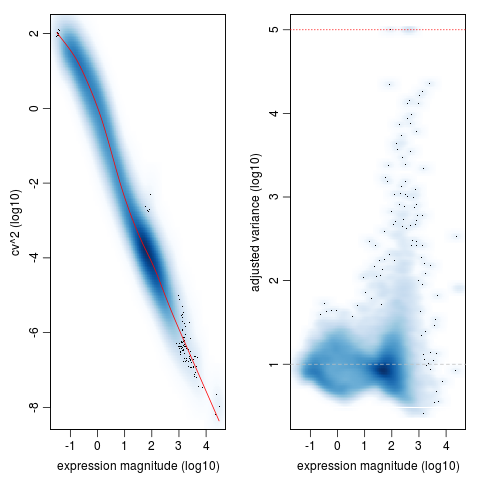

In [59]:
%%R

#####format
test <- apply(
    counts(scdata),
    2,
    function(x) {
        storage.mode(x) <- 'integer'
        return(x)
    }
)

x <- colData(scdata)$sc3_4_clusters

l2cols <- c("coral4", "olivedrab3", "skyblue2", "cornsilk")[as.integer(factor(x, levels = c("1", "2", "3","4")))]

###run error modelling

knn <- knn.error.models(test, k = ncol(test)/4, n.cores = 4, min.count.threshold = 2, min.nonfailed = 5, max.model.plots = 10)

varinfo <- pagoda.varnorm(knn, counts = test, trim = 2/ncol(test), max.adj.var = 5, n.cores = 4, plot = TRUE)

varinfo <- pagoda.subtract.aspect(varinfo, colSums(test[, rownames(knn)]>0))

####run gene sets analysis

library(org.Hs.eg.db)

ids <- unlist(lapply(mget(rownames(test), org.Hs.egENSEMBL2EG, ifnotfound = NA), function(x) x[1]))
rids <- names(ids); names(rids) <- ids 
gos.interest <- unique(c(ls(org.Hs.egGO2ALLEGS))) 
go.env <- lapply(mget(gos.interest, org.Hs.egGO2ALLEGS), function(x) as.character(na.omit(rids[x]))) 
go.env <- clean.gos(go.env) # remove GOs with too few or too many genes
go.env <- list2env(go.env) # convert to an environment

#### pagoda

pwpca <- pagoda.pathway.wPCA(varinfo, go.env, n.components = 1, n.cores = 4)

png(filename = "1.png")
df <- pagoda.top.aspects(pwpca, return.table = TRUE, plot = TRUE, z.score = 1.96)
dev.off()

head(df)

write.table(df, file = "scde/gsea_GO.txt", row.names = TRUE, col.names = TRUE, sep = "\t", quote = FALSE)

png(filename = "2.png")
clpca <- pagoda.gene.clusters(varinfo, trim = 7.1/ncol(varinfo$mat), n.clusters = 50, n.cores = 4, plot = TRUE)
dev.off()

png(filename = "3.png")
df <- pagoda.top.aspects(pwpca, clpca, return.table = TRUE, plot = TRUE, z.score = 1.96)
dev.off()

write.table(df, file = "scde/gsea_deNovo.txt", row.names = TRUE, col.names = TRUE, sep = "\t", quote = FALSE)

######visualize

tam <- pagoda.top.aspects(pwpca, clpca, n.cells = NULL, z.score = qnorm(0.01/2, lower.tail = FALSE))

hc <- pagoda.cluster.cells(tam, varinfo)

tamr <- pagoda.reduce.loading.redundancy(tam, pwpca, clpca)

png(filename = "4.png")
tamr2 <- pagoda.reduce.redundancy(tamr, distance.threshold = 0.9, plot = TRUE, cell.clustering = hc, labRow = NA, labCol = NA, box = TRUE, margins = c(0.5, 0.5), trim = 0)
col.cols <- rbind(groups = cutree(hc, 4))
pagoda.view.aspects(tamr2, cell.clustering = hc, box = TRUE, labCol = NA, margins = c(0.5, 20), col.cols = rbind(l2cols))
dev.off()

png(filename = "5.png")
pagoda.view.aspects(tamr2, cell.clustering = hc, row.clustering = NA, box = TRUE, labCol = NA, margins = c(0.5, 20), col.cols = rbind(l2cols))
dev.off()

In [61]:
%%R

save(file="121417.RData")

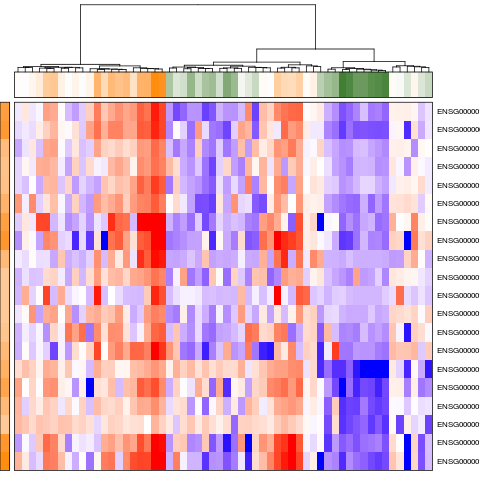

In [75]:
%%R

##pull out individual genes

pagoda.show.pathways(c("GO:0000982"), varinfo, go.env, cell.clustering = hc, margins = c(1,5), show.cell.dendrogram = TRUE, showRowLabels = TRUE, showPC = TRUE)


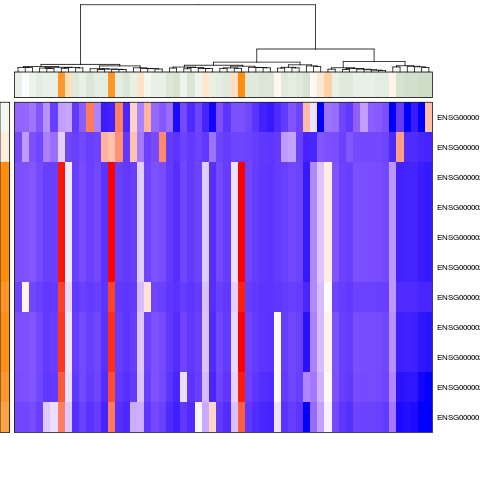

In [79]:
%%R

##pull out individual genes
test.pattern <- pagoda.show.pathways(c("GO:0052695"), varinfo, go.env, show.cell.dendrogram = TRUE, cell.clustering = hc, showRowLabels = TRUE)

varinfo.test <- pagoda.subtract.aspect(varinfo, test.pattern)

In [80]:
%%R

table(clpca$clusters$geneCluster.22)



ENSG00000022556 ENSG00000060303 ENSG00000075131 ENSG00000089009 ENSG00000089157 
              1               1               1               1               1 
ENSG00000101278 ENSG00000105640 ENSG00000111775 ENSG00000111780 ENSG00000114391 
              1               1               1               1               1 
ENSG00000116251 ENSG00000121089 ENSG00000122026 ENSG00000124399 ENSG00000124614 
              1               1               1               1               1 
ENSG00000125144 ENSG00000131885 ENSG00000135406 ENSG00000136149 ENSG00000137970 
              1               1               1               1               1 
ENSG00000140988 ENSG00000143429 ENSG00000145425 ENSG00000146677 ENSG00000147403 
              1               1               1               1               1 
ENSG00000148303 ENSG00000150625 ENSG00000152936 ENSG00000156508 ENSG00000162244 
              1               1               1               1               1 
ENSG00000162840 ENSG0000016

In [74]:
pagoda.view.aspects(tamr2, cell.clustering = hc, row.clustering = NA, box = TRUE, labCol = NA, margins = c(0.5, 20), col.cols = rbind(l2cols))




NULL
